In [2]:
# ✅ Step 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

import os
import matplotlib.pyplot as plt
from PIL import Image


In [3]:
# ✅ Step 2: Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import zipfile

zip_path = "/content/drive/MyDrive/newproject/archive (2).zip"  # Your Drive path
extract_path = "/content/animals"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
# !mv /content/animals/animals/* /content/animals/


In [6]:
import os

# List folders under the extraction path
print("Folders inside /content/animals:")
print(os.listdir("/content/animals"))


Folders inside /content/animals:
['animals']


In [7]:
cat_images = os.listdir("/content/animals/animals/cat")[:5]
dog_images = os.listdir("/content/animals/animals/dog")[:5]

print("Cat images:", cat_images)
print("Dog images:", dog_images)


Cat images: ['00144-200124454.png', '00016-4122619889.png', '00181-200124491.png', '00268-200124578.png', '00216-200124526.png']
Dog images: ['00666-3846168828.png', '00589-3846168751.png', '00860-3846169022.png', '00510-3846168672.png', '00672-3846168834.png']


In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Cat preview
print("🐱 Cat images:")
for img_name in cat_images:
    img_path = os.path.join("/content/animals/animals/cat", img_name)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title("Cat")
    plt.axis("off")
    plt.show()

# Dog preview
print("🐶 Dog images:")
for img_name in dog_images:
    img_path = os.path.join("/content/animals/animals/dog", img_name)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title("Dog")
    plt.axis("off")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [9]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # for VGG16, ResNet, etc.
                         std=[0.229, 0.224, 0.225])
])


In [10]:
from torchvision import datasets

data_dir = "/content/animals/animals"  # correct root folder

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
print("Classes:", class_names)


Classes: ['cat', 'dog']


In [11]:
print("Total images:", len(dataset))


Total images: 1000


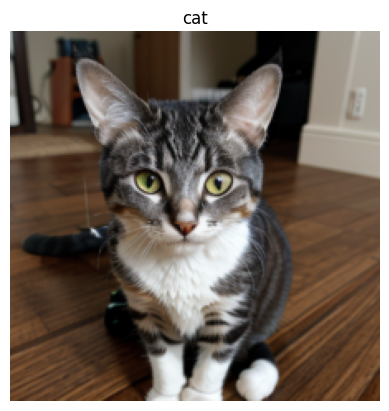

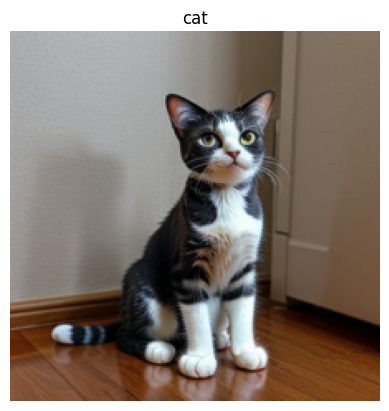

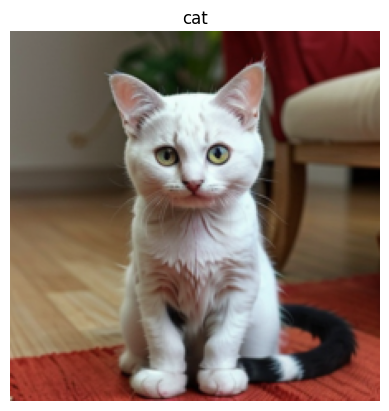

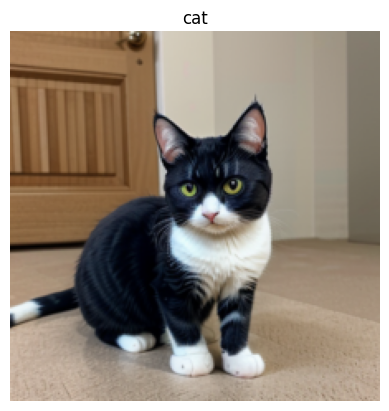

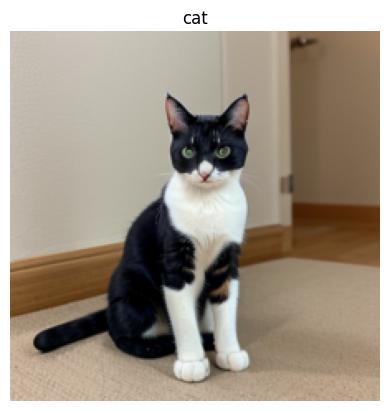

In [12]:
import torch
import matplotlib.pyplot as plt

def show_image(img_tensor, label):
    img = img_tensor.permute(1, 2, 0).numpy()
    mean = torch.tensor([0.485, 0.456, 0.406]).numpy()
    std = torch.tensor([0.229, 0.224, 0.225]).numpy()

    img = img * std + mean  # unnormalize
    img = img.clip(0, 1)

    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')
    plt.show()

for i in range(5):
    image, label = dataset[i]
    show_image(image, label)


In [13]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [15]:
vgg16 = models.vgg16(pretrained=True)

# Freeze convolutional layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# Replace last classifier layer for 2 classes (cat, dog)
vgg16.classifier[6] = nn.Linear(4096, 2)

# Move model to device
vgg16 = vgg16.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 106MB/s]


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg16.parameters()), lr=0.001)


In [26]:
class SimpleTrainer:
    def __init__(self, model, device, train_loader, test_loader, criterion, optimizer):
        self.model = model.to(device)
        self.device = device
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer

    def train_epoch(self):
        self.model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in self.train_loader:
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        return total_loss / total, 100 * correct / total

    def evaluate(self):
        self.model.eval()
        total_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        return total_loss / total, 100 * correct / total

    def fit(self, epochs):
        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch()
            test_loss, test_acc = self.evaluate()
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


In [27]:
trainer = SimpleTrainer(
    model=vgg16,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer
)


In [28]:
trainer.fit(epochs=5)


Epoch 1/5 | Train Loss: 0.0435, Train Acc: 98.00% | Test Loss: 1.2610, Test Acc: 99.00%
Epoch 2/5 | Train Loss: 1.6745, Train Acc: 98.50% | Test Loss: 0.0000, Test Acc: 100.00%
Epoch 3/5 | Train Loss: 0.1596, Train Acc: 99.75% | Test Loss: 5.6885, Test Acc: 99.00%
Epoch 4/5 | Train Loss: 0.0001, Train Acc: 100.00% | Test Loss: 3.7771, Test Acc: 99.00%
Epoch 5/5 | Train Loss: 0.0000, Train Acc: 100.00% | Test Loss: 3.1821, Test Acc: 99.00%


In [29]:
torch.save(vgg16.state_dict(), "/content/vgg16_dogcat.pth")
print("Model saved successfully!")


Model saved successfully!


In [30]:
# Save only the model weights (state_dict)
torch.save(vgg16.state_dict(), "/content/vgg16catdog.pth")
print("Model saved as vgg16catdog.pth!")


Model saved as vgg16catdog.pth!


In [32]:
vgg16classifier = models.vgg16(pretrained=False)
vgg16classifier.classifier[6] = nn.Linear(4096, 2)

vgg16classifier.load_state_dict(torch.load("/content/vgg16catdog.pth"))
vgg16classifier = vgg16classifier.to(device)
vgg16classifier.eval()

print("Model loaded successfully and ready for prediction.")


Model loaded successfully and ready for prediction.


In [40]:
# Define transformation (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # VGG16 normalization
                         std=[0.229, 0.224, 0.225])
])

# Load your image
image_path = "/content/cat2.jpg"  # Change this to your actual image path
img = Image.open(image_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

# Run prediction
vgg16classifier.eval()
with torch.no_grad():
    output = vgg16classifier(img_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

# Map to label
class_names = ["cat", "dog"]  # Make sure this matches your label order during training
print(f"Predicted class: {class_names[predicted_class]}")

Predicted class: dog
